In [1]:
%%capture

import pandas as pd
import numpy as np
import tensorflow as tf
import mlts

import altair as alt
alt.renderers.enable('notebook')

## Load data

In [2]:
data = mlts.io.merge([
    pd.read_csv('../data/fashion-mnist/fashion-mnist_train.csv'),
    pd.read_csv('../data/fashion-mnist/fashion-mnist_train.csv'),
])

In [3]:
mlts.io.check(data)

In [4]:
K = len(data.iloc[:, 0].value_counts())
dss, mu, sigma = mlts.io.normalize(mlts.io.split(data, ycol=0, shape=(42048), seed=1))
(ds_train, ds_dev, ds_test) = mlts.tf.to_dataset(dss, batch_size=32)

## Implement the model

In [5]:
class FasionMNISTAdapter(mlts.tf.adapter.Model):
    def __init__(self, *args, **kwargs):
        super(FasionMNISTAdapter, self).__init__(*args, **kwargs)

    @staticmethod
    def model(options, hparams = {}):
        regularization = None
        if "lambda" in hparams:
            regularization = tf.keras.regularizers.l2(l=hparams["lambda"])

        return tf.keras.models.Sequential([
            ## The reason of using 'InputLayer' is only to
            ## show up a shape of each layer in `model.summary()`.
            tf.keras.layers.InputLayer(input_shape=(784)),
            tf.keras.layers.Dense(
                16,
                activation=tf.nn.relu,
                kernel_initializer=tf.keras.initializers.he_uniform(options.seed),
                kernel_regularizer=regularization,
            ),
            tf.keras.layers.Dense(
                16,
                activation=tf.nn.relu,
                kernel_initializer=tf.keras.initializers.he_uniform(options.seed),
                kernel_regularizer=regularization,
            ),
            tf.keras.layers.Dense(
                K,
                activation=tf.nn.softmax,
                kernel_initializer=tf.keras.initializers.he_uniform(options.seed),
                kernel_regularizer=regularization,
            )
        ])

    @staticmethod
    def loss(options):
        return tf.keras.losses.SparseCategoricalCrossentropy()

    @staticmethod
    def optimization(options, hparams, m, ds, metrics=[], callbacks=[]):
        _loss = FasionMNISTAdapter.loss(options)
        _optimizer = tf.keras.optimizers.Adam()
        _accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        _loss_metric = tf.keras.metrics.Mean()

        for epoch in range(options.epochs):
            for step, (X, y) in enumerate(ds):
                with tf.GradientTape() as tape:
                    h = m(X)
                    j = _loss(y, h)

                    _loss_metric(j)
                    _accuracy_metric(y, h)

                dJ = tape.gradient(j, m.trainable_weights)
                _optimizer.apply_gradients(zip(dJ, m.trainable_weights))

            print("epoch={} loss={} accuracy={}"
                  .format(epoch, _loss_metric.result(), _accuracy_metric.result()))
                    
        return m

In [6]:
model = FasionMNISTAdapter.model(mlts.tf.adapter.Options(seed=1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


## Analyze the dataset

W0810 18:11:16.412894 4476982720 deprecation.py:323] From /Users/manifest/projects/github/machine-learning-notebook/venv/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch=0 loss=2.831925630569458 accuracy=0.09375
epoch=0 loss=2.805577278137207 accuracy=0.078125
epoch=0 loss=2.834336280822754 accuracy=0.0625
epoch=0 loss=2.7976672649383545 accuracy=0.0703125
epoch=0 loss=2.7541260719299316 accuracy=0.07500000298023224
epoch=0 loss=2.6943273544311523 accuracy=0.0833333358168602
epoch=0 loss=2.627959728240967 accuracy=0.09375
epoch=0 loss=2.5751559734344482 accuracy=0.11328125
epoch=0 loss=2.542374610900879 accuracy=0.1180555522441864
epoch=0 loss=2.503554582595825 accuracy=0.12812499701976776


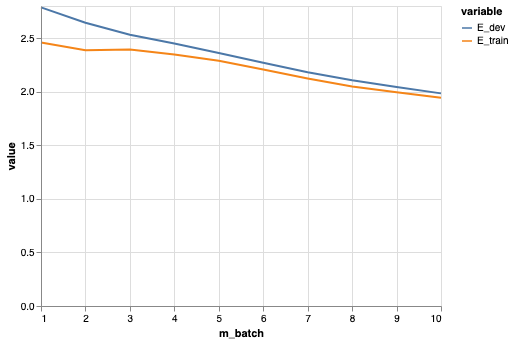

In [7]:
m_hist = FasionMNISTAdapter.analyze_dataset(
    mlts.tf.adapter.Options(epochs=1, seed=1),
    {},
    ds_train.take(10),
    ds_dev.take(10)
)
alt.Chart(m_hist.melt(id_vars="m_batch")).mark_line().encode(
    x = "m_batch",
    y = "value",
    color = "variable"
)

## Evaluate the model

In [8]:
ad = FasionMNISTAdapter(mlts.tf.adapter.Options(epochs=1, seed=1))
ad.fit(ds_train)

epoch=0 loss=0.5739279985427856 accuracy=0.800561249256134
